In [ ]:
import glob
from func import *
import pandas as pd
import csv
import numpy as np
from statsmodels.sandbox.stats.multicomp import multipletests
import sys 
sys.path.append("..") 
sys.path.append("../scripts")
from scripts import process_ptb, process_ctb
from utils import *
# from scripts import process_ptb, process_ctb
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgba


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 


# Response Process
The results of parallel sentences can be directly processed, without annotations of treebanks.

But you can also replicate our results by using our processed data, which can be directly used in the **Visualization** section.

In [ ]:

parsed_file = pd.read_csv('stimulus/constituency_tree.csv',
            delimiter='\t',
            quoting=csv.QUOTE_NONE,
            quotechar=None)
sentence = parsed_file['sentence'].values.tolist()
parsed = parsed_file['tree'].values.tolist()
en_parsed_lst = []
zh_parsed_lst = []
for sent, tree in zip(sentence, parsed):
    if len(re.findall('[^\u4e00-\u9fa5]', sent)) != 0:
        en_parsed_lst.append([sent, tree])
    else:
        zh_parsed_lst.append([sent, tree])
en_cons_feature_dict, _ = process_ptb.get_cons_feature(en_parsed_lst)
cons_feature_dict, _ = process_ctb.get_cons_feature(zh_parsed_lst)
cons_feature_dict.update(en_cons_feature_dict)

## ChatGPT

In [ ]:
# English

total_result_en = []
paths = glob.glob(f"result/english/chatgpt/*.csv")
for p in paths:
    result = []
    resp_file = pd.read_csv(p,
                    delimiter='\t',
                    quoting=csv.QUOTE_NONE,
                    quotechar=None,)
    for idx, row in resp_file.iterrows():
        result.append(row.tolist())
    total_result_en.append(result)


# Chinese

total_result_zh = []
paths = glob.glob(f"result/chinese/chatgpt/*.csv")
for p in paths:
    result = []
    resp_file = pd.read_csv(p,
                    delimiter='\t',
                    quoting=csv.QUOTE_NONE,
                    quotechar=None,)
    for idx, row in resp_file.iterrows():
        result.append(row.tolist())
    total_result_zh.append(result)

total_phrase = []
for result in total_result_en:
    
    phrase_sent, mixed_sent, word_sent, fail_sent = process_ptb.ptb_constituent_analysis(result, cons_feature_dict)
    total_phrase.append(phrase_sent)

for result in total_result_zh:
    phrase_sent, word_sent, char_sent, fail_sent = process_ctb.ctb_constituent_analysis(result, cons_feature_dict)
    total_phrase.append(phrase_sent)
    


# 删除item的结点类型
total_node = []

# 删除item的父节点类型
total_parent = []

for phrase_sent in total_phrase:
    node_lst = []
    parent_lst = []

    for phrase_item in phrase_sent:
        if ' ' in phrase_item[0]:
            if len(phrase_item[0].split(' ')) - len(phrase_item[1].split(' ')) == 1:
                continue
        else:
            if len(list(phrase_item[0])) - len(list(phrase_item[1])) == 1:
                continue
        cons_feature = cons_feature_dict[phrase_item[0]]
        for test_label_cons in phrase_item[2]:
            node = test_label_cons.split('-')[0]
            parent = cons_feature[5][test_label_cons][-1].split('-')[0]
            node_lst.append(node)
            parent_lst.append(parent)
    total_node.append(node_lst)
    total_parent.append(parent_lst)

node_explained = []
parent_explained = []
for node_lst, parent_lst in zip(total_node, total_parent):
    node_rate = 0
    parent_rate = 0
    for node, parent in zip(node_lst, parent_lst):
        if node == 'NP' and parent == 'VP':
            continue
        if node == 'NP':
            node_rate+=1
        if parent == 'VP':
            parent_rate += 1
    node_explained.append(node_rate / len(node_lst))
    parent_explained.append(parent_rate / len(parent_lst))




## Human

In [ ]:
def process_human_result(paths):
    total_result_lst = []
    for p in paths:
        res_file = pd.read_csv(p,
                            delimiter='\t',
                            quoting=csv.QUOTE_NONE,
                            quotechar=None)
        result = []
        for index, row in res_file.iterrows():
            orig = row['original']
            pred = row['prediction']
            if pd.isna(pred):
                result.append([orig, 'fail to follow', row['demonstration']])
                continue
            pred = re.sub(r'\W', ' ', pred)
            pred = pred.split(' ')
            pred = list(filter(lambda x: x and x.strip(), pred))
            pred = ' '.join(pred)
            if not set(list(pred.lower().split(' '))).issubset(set(list(orig.lower().split( )))) :
                pred = 'fail to follow'
            elif pred == orig:
                pred = 'fail to follow'
            result.append([orig, pred, row['demonstration']])
        total_result_lst.append(result)
    return total_result_lst

def load_subj_explained(result_lst, subj_type, cons_feature_dict):

    inter_subj = []
    for result in result_lst:
        node_type = []
        parent_type = []
        demon = [item[-1] for item in result]
        result = [item[:-1] for item in result]
        if 'zh' in subj_type:
            phrase_sent, word_sent, char_sent, fail_sent = process_ctb.ctb_constituent_analysis(result, cons_feature_dict)
        else:
            phrase_sent, mixed_sent, word_sent, fail_sent = process_ptb.ptb_constituent_analysis(result, cons_feature_dict, demon)

        for phrase_item in phrase_sent:
            cons_feature = cons_feature_dict[phrase_item[0]]
            for cons in phrase_item[2]:
                test_node = cons.split('-')[0]
                test_parent = cons_feature[-2][cons][-1].split('-')[0]
                node_type.append(['NP', test_node])
                parent_type.append(['VP', test_parent])

        inter_subj.append([node_type, parent_type])
    plot_data = []
    for subj in inter_subj:
        if len(subj[0]) ==0:
            continue 
        node_rate = 0
        parent_rate = 0
        total = 0
        for node, parent in zip(subj[0], subj[1]):
            # print(node)
            if node[0] == node[1] and parent[0] == parent[1]:
                continue
            if node[0] == node[1]:
                node_rate += 1
            if parent[0] == parent[1]:
                parent_rate += 1

            total += 1
        if total == 0:
            continue

        plot_data.append([node_rate / total, parent_rate / total])
    return plot_data


zh_paths = glob.glob('result/chinese/native/*.csv')
en_paths = glob.glob('result/english/l2/*.csv')
zh_result = process_human_result(zh_paths)
en_result = process_human_result(en_paths)
zh_explained = load_subj_explained(zh_result, 'zh', cons_feature_dict)
en_explained = load_subj_explained(en_result, 'en', cons_feature_dict)


# Visualization

model-en significance test, original:  0.00019998000199980003 FDR corrected:  0.00026664000266640004
human-en significance test, original:  0.00019998000199980003 FDR corrected:  0.00026664000266640004
model-zh significance test, original:  0.00019998000199980003 FDR corrected:  0.00026664000266640004
human-zh significance test, original:  0.003999600039996 FDR corrected:  0.003999600039996


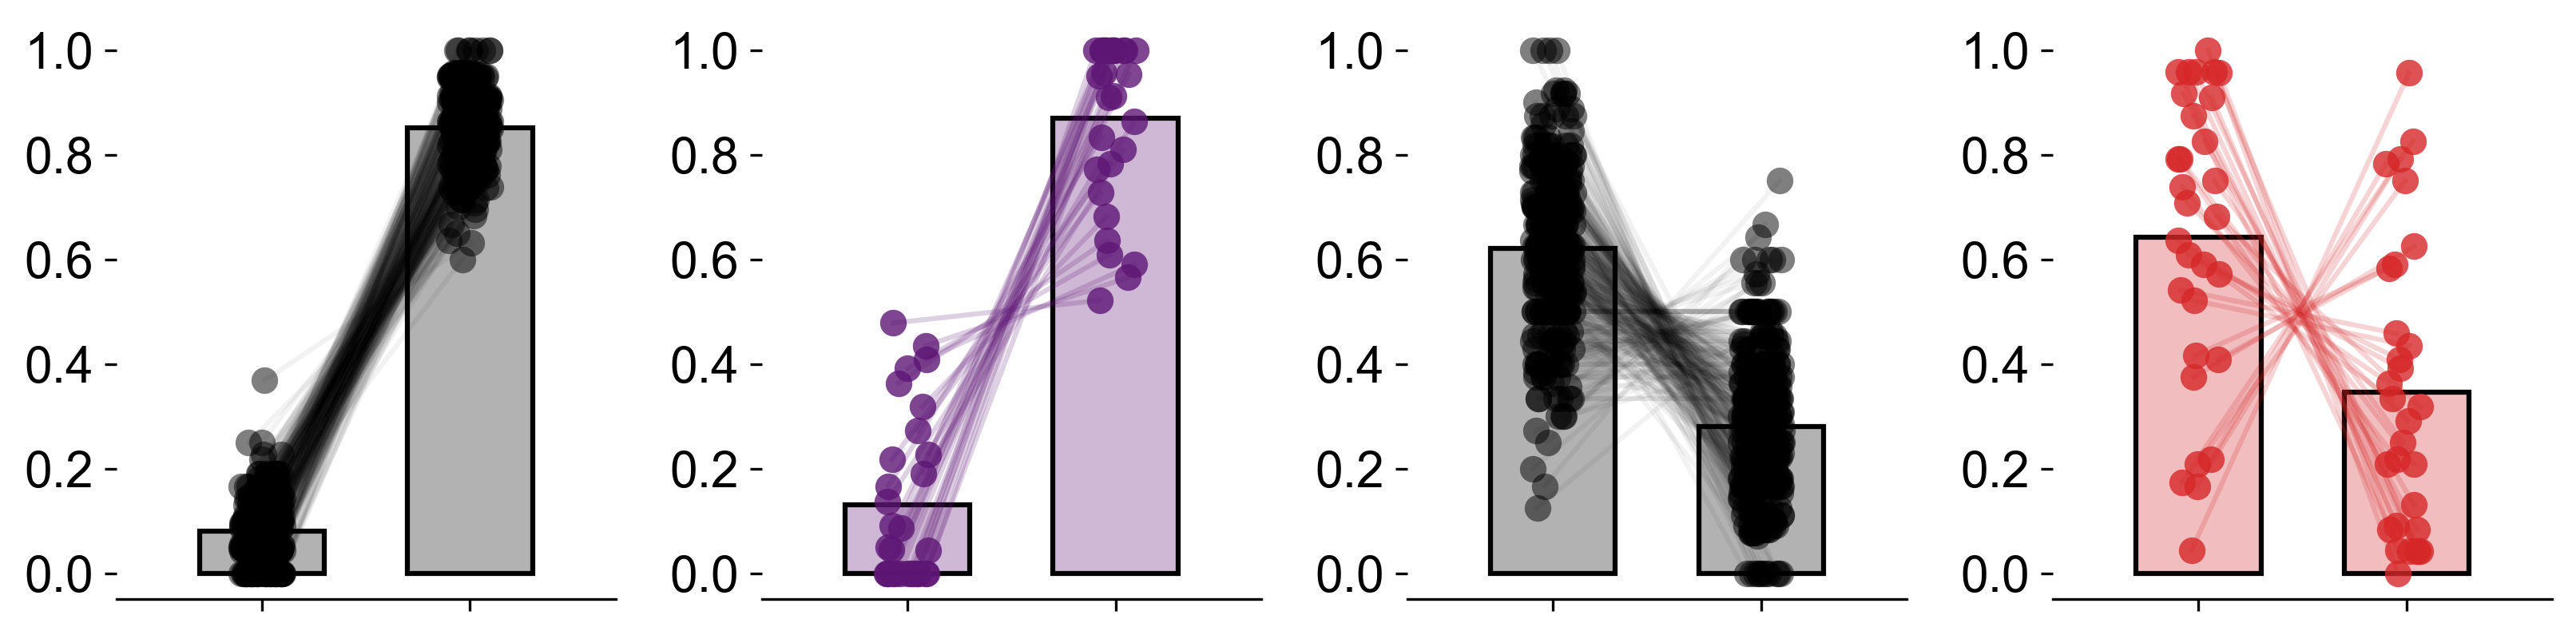

In [ ]:
df = read_pkl('processed_data/explained_ratio.pkl')

fig, axes = plt.subplots(1,4, figsize=(11,2.9))
sns.despine(top=True, right=True, left=True, bottom=False)
sns.set_context(rc = {'patch.linewidth': 1.5})
model_lst = ['model-en', 'human-en', 'model-zh', 'human-zh']
pvals = []
for idx, (ax, prefix) in enumerate(zip(axes, model_lst,)):
    plot_df = df[df.iloc[:,0].str.contains(prefix + '_')]
    palette = {

        'model-en': 'k',
        'model-zh': 'k',
        'human-en': '#5E1675',
        'human-zh': '#d62728',
    }

    color = palette[prefix]
    g = sns.barplot(data = plot_df, x='subj', y='value', ax=ax, 
                    color=color,
                    errorbar = None,  
                    capsize=.1, 
                    width=0.6,
                    edgecolor = (0,0,0,1),
                    )
    for i, bar in enumerate(g.patches):
        color = color
        bar.set_facecolor(to_rgba(color, 0.3))
        bar.set_edgecolor((0, 0, 0, 1))
    if 'model' in prefix:
        alpha = 0.5
    else:
        alpha=0.8
    g = sns.stripplot(data=plot_df, x='subj', y='value', ax=ax, 
                      size=8, color=color, edgecolors='k', alpha=alpha)
    if idx < 2:
        a = ax.scatter([1,2],[3,4], marker='o')
        b = ax.scatter([1,2],[3,4], marker='o')
    else:
        a = ax.scatter([1,2],[3,4], marker='o')
        b = ax.scatter([1,2],[3,4], marker='o')
    square_mk, = a.get_paths()
    triangle_up_mk, = b.get_paths()
    a.remove()
    b.remove()
    N_hues = len(pd.unique(plot_df.subj))

    c = ax.collections
    for a in c[::N_hues]:
        a.set_paths([triangle_up_mk])
    for a in c[1::N_hues]:
        a.set_paths([square_mk])
    #update legend
    ax.legend(c[-2:],pd.unique(plot_df.subj))


    set1 = plot_df[plot_df['subj'] == prefix+'_node']['value'].tolist()
    set2 = plot_df[plot_df['subj'] == prefix+'_parent']['value'].tolist()
    pvals.append([prefix, paired_bootstrap_test(set1, set2)])

    idx0 = 2
    idx1 = 3
    locs1 = ax.get_children()[idx0].get_offsets()
    locs2 = ax.get_children()[idx1].get_offsets()

    sort_idxs1 = np.argsort(set1)
    sort_idxs2 = np.argsort(set2)

    locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]
    locs2_sorted = locs2
    if 'model' in prefix:
        alpha = 0.05
    else:
        alpha=0.2
    for i in range(locs1.shape[0]):
        x = [locs1[i, 0], locs2_sorted[i, 0]]
        y = [locs1[i, 1], locs2_sorted[i, 1]]
        ax.plot(x, y, color=color, alpha=alpha)
    g.set(xlim=[-0.7,1.7])
    g.set(ylim=[-0.05, 1.05])
    # g.set(ylim=[0.1, 1.05])
    g.set(yticks=[0,0.2,0.4,0.6,0.8,1.0])
    g.set(ylabel='')
    g.set(xlabel='')
    g.set(xticklabels='')

    ax.legend([],[], frameon=False)
plt.tight_layout()

reject, pvals_corrected, _, _ = multipletests([p[1] for p in pvals], alpha=0.05, method='fdr_bh')
for p, corrected_p in zip(pvals, pvals_corrected):
    print(p[0], 'significance test, original: ', p[1], 'FDR corrected: ', corrected_p)


## Correlation analysis

(0.8064952677421497, 7.409688854232916e-08)


[Text(0, 0.5, '  ')]

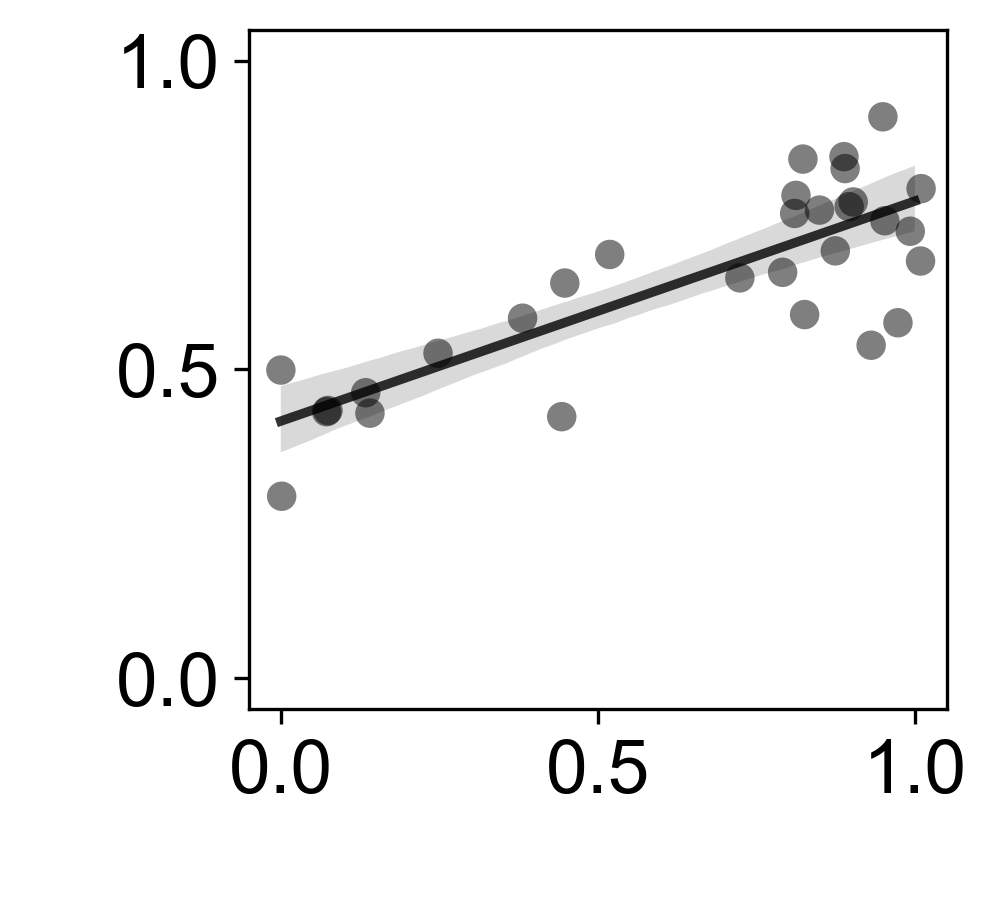

In [ ]:
from scipy.stats import pearsonr
target_file = pd.read_csv(f"stimulus/test_sentence.csv",
                delimiter='\t',
                quoting=csv.QUOTE_NONE,
                quotechar=None,)
target_lst_en = target_file['english'].values.tolist()
target_lst_zh = target_file['chinese'].values.tolist()
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(1,  1, figsize=(3,3))

sent_info = read_pkl("processed_data/explained_ratio_across_sentence.pkl")
df_en = {'human':[], 
         'model':[],}


for idx, sent in enumerate(target_lst_en):
    info = sent_info[sent.lower()]
    # info[1][0] node-rule of human
    # info[0][0] node-rule of chatGPT

    # info[1][1] parent-rule of human
    # info[0][1] parent-rule of chatGPT
    df_en['human'].append(info[1][0])
    df_en['model'].append(info[0][0])


df_zh = {'human':[], 
         'model':[],
}


for idx, sent in enumerate(target_lst_zh):
    info = sent_info[sent]
    df_zh['human'].append(info[1][0])
    df_zh['model'].append(info[0][0])
    
# use df_en to calculate the correlation in English
df = pd.DataFrame.from_dict(df_zh)

g = sns.regplot(data=df, x="model", 
                y="human", ax=ax, 
                x_jitter=0.01, y_jitter=0.01, color = 'k',
                scatter_kws={'alpha':0.5, 'edgecolor':'none', 's':50, "marker":'o'},
                line_kws={'alpha':0.8})

print(pearsonr(df["human"], df["model"]))


g.set(yticks=[0,0.5,1.0])
g.set(xticks=[0,0.5,1.0])
g.set(yticklabels=['0.0','0.5','1.0'])
g.set(xticklabels=['0.0','0.5','1.0'])
g.set(xlim=[-0.05,1.05])
g.set(ylim=[-0.05,1.05])
g.set(xlabel='  ')
g.set(ylabel='  ')

## Correlation to collocation strength

(-0.5556962549378124, 0.001432292353814152)


[Text(0, 0.5, '  ')]

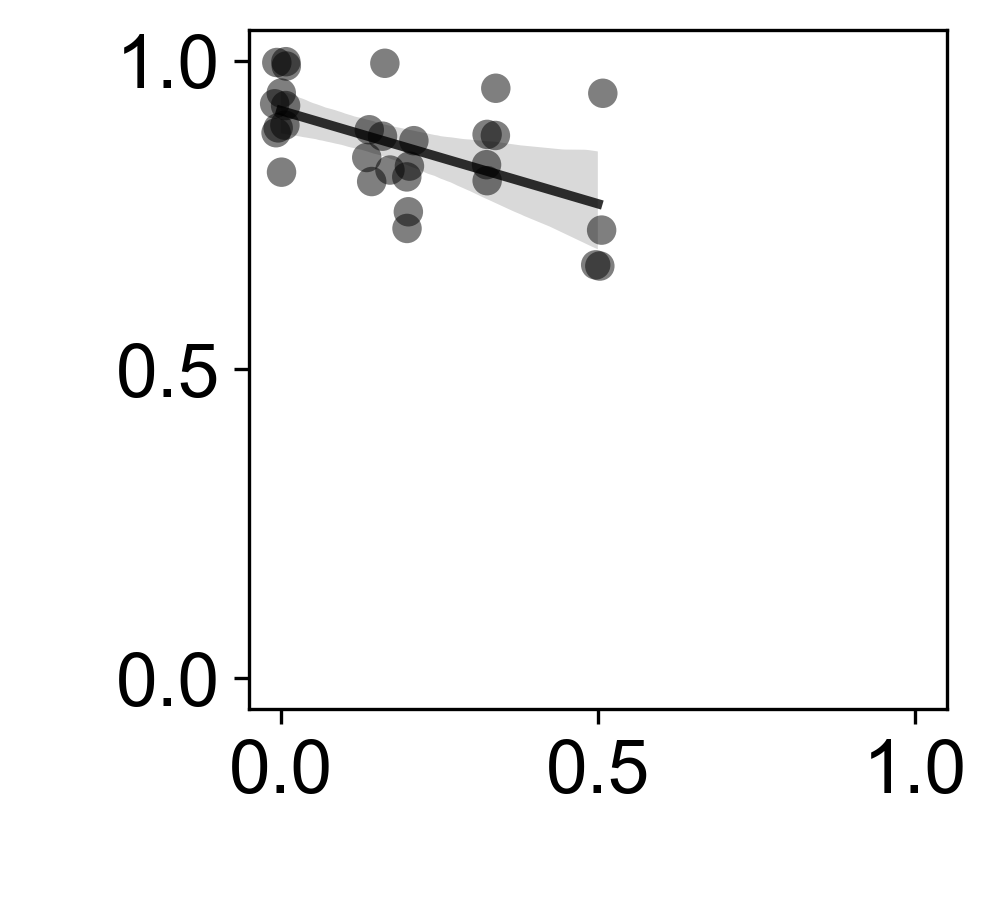

In [ ]:
plt.rcParams['font.size'] = 18
fig, ax = plt.subplots(1,  1, figsize=(3,3))

# the collocation strength is calculated based on Oxford Collocation Dictionary
excel_dict = {"the students look at the complex equation":0.5 ,
"the old man looked at the window":0.5 ,
"the old map points to a hidden treasure":0.2 ,
"the young boy looks at the toy store window":0.5 ,
"the road sign points to the nearest exit":0.2 ,
"his father died of a heart attack":0.333 ,
"the little girl walks towards the living room":0.142857 ,
"his parents rushed to his side":0.16667,
"many squirrels live in the oak tree":0.2 ,
"a surprising revelation happened on their wedding anniversary":0 ,
"a lost puppy walks towards the city park":0.142857 ,
"his family lived in an old farmhouse":0.2 ,
"his glasses lie on the bedside table":0.333,
"most people live in rural areas":0.2 ,
"the secret letter lies on the old wooden desk":0.33 ,
"the fresh linens lie in the laundry basket":0.00 ,
"a gentleman walks towards the bustling cafe":0.142857 ,
"the great artist died from a serious illness":0.33333 ,
"the old guests sat at the dinner table":0.16667 ,
"the story begins in a small town":0.00 ,
"the golden treasure lies in the dense jungle":0.00 ,
"a picture hangs at his study":0.00 ,
"the rare artifact stays in the secured vault":0.00 ,
"the bird rests on the sturdy branch":0.50 ,
"the fragile vase stays on the top shelf":0.00 ,
"the thick essay lies on the shelf":0.333 ,
"a full moon appeared in the dark night sky":0.00 ,
"the accident happened on saturday night":0.00 ,
"the small boat stays in the calm lake":0.00 ,
"the rest students sat on the ground":0.166667}


df_en = {'explained':[], 
         'collocation':[],}

for idx, sent in enumerate(target_lst_en):
    info = sent_info[sent.lower()]
    excel_info = excel_dict[sent.lower()]
    # info[1][0] node-rule of human
    # info[0][0] node-rule of chatGPT

    # info[1][1] parent-rule of human
    # info[0][1] parent-rule of chatGPT
    df_en['explained'].append(info[1][0])
    df_en['collocation'].append(excel_info)


df = pd.DataFrame.from_dict(df_en)

g = sns.regplot(data=df, x="collocation", 
                y="explained", ax=ax, 
                x_jitter=0.01, y_jitter=0.01, color = 'k',
                scatter_kws={'alpha':0.5, 'edgecolor':'none', 's':50, "marker":'o'},
                line_kws={'alpha':0.8})

print(pearsonr(df["collocation"], df["explained"]))


g.set(yticks=[0,0.5,1.0])
g.set(xticks=[0,0.5,1.0])
g.set(yticklabels=['0.0','0.5','1.0'])
g.set(xticklabels=['0.0','0.5','1.0'])
g.set(xlim=[-0.05,1.05])
g.set(ylim=[-0.05,1.05])
g.set(xlabel='  ')
g.set(ylabel='  ')